### Feature Extractor

In [1]:
import math

import networkx as nx
import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import date
from tqdm import tqdm
from itertools import product

distant_df = pd.read_csv('data/us_air_distance.csv')
distant_map = distant_df.set_index(['source_origin','target_origin']).to_dict()['distance']
distant_map.update(distant_df.set_index(['target_origin','source_origin']).to_dict()['distance'])
population_map = pd.read_csv('data/us_air_population_all.csv').set_index('Unnamed: 0').fillna(0).to_dict()['0']

def get_gravitation(edges):
    def my_divid(a,b):
        if b==0 or a==0:
            return None
        else:
            return a/b
    Gra = []
    for e in edges:
        u, v = e #2 cities on each side of one edge
        d = distant_map.get(e , 0) #distance between these 2 cities
        ni = population_map.get(u, 0) #population of each city
        nj = population_map.get(v, 0)
        Gra.append(my_divid(ni*nj, d**2)) #calculate gravitation of this edge
    meanv = np.mean([i for i in Gra if i]) #get mean of gravitation (population * population / distance**2)
    return [i if i else meanv for i in Gra]

def features_extractor(graphs, dates):
    #concert a sparse adjacency matrix to a dense matrix.
    #the epsilon value of path is used to determine the degree of exploration in algorithms  to find the shortest path between two nodes in a graph. 
    #The higher the epsilon value is, the more exploration of the possible paths between two nodes in a graph.
    def local_path(G, nodeList, epsilon = 0.01):
        A = nx.adjacency_matrix(G, nodelist=nodeList, weight = None).todense() 
        return (A**2+epsilon*A**3)

    def l3_path(G, nodeList):
        A = nx.adjacency_matrix(G, nodelist=nodeList, weight = None).todense()
        return (A**3)

    def weighted_local_path(G, nodeList, epsilon = 0.01):
        A = nx.adjacency_matrix(G, nodelist=nodeList, weight='weight').todense()
        return (A**2+epsilon*A**3)
    #a weighted local path is a local path where the weight of each edge is taken into account when calculating the distance
    #the weight of an edge is the number of flights during the monthly observation window. 

    X = defaultdict(list)
    for i in tqdm(range(len(graphs)-1)):
        G, H = graphs[i], graphs[i+1]
        G.add_nodes_from([n for n in H if n not in G])
        H.add_nodes_from([n for n in G if n not in H])
        Hedges = set(H.edges())
        Gedges = list(G.edges())
        nodeList = list(G.nodes())
        nodeIndex = {node: idx for idx,node in enumerate(nodeList)}
        year = dates[i]

        Ki = dict(G.degree())
        Wi = dict(G.degree(weight='weight'))
        LPI = local_path(G, nodeList)
        L3 = l3_path(G, nodeList)
        WLPI = weighted_local_path(G, nodeList)
        Gra = get_gravitation(Gedges)

        added_edges = list(nx.difference(H,G).edges())

        for j, e in enumerate(Gedges):
            u, v = e
            common_ns = list(nx.common_neighbors(G,u,v))
            # returns the common neighbors of two nodes in a graph, which means nodes that connects both to these two nodes (could be 0)
            w_common_ns = sum([min(G[u][z]['weight'], G[v][z]['weight']) for z in common_ns])
            # compare the weights of each common neighbor to these two nodes, choose the minimum one and then sum up.
            union_ns = set(G.neighbors(u))|set(G.neighbors(v)) 
            #union operation on two sets -> return to a new set containing all the elements from both set1 and set2
            w_union_ns = Wi[u] + Wi[v]- w_common_ns
            if(w_union_ns==0): print(Wi[u] , Wi[v], [min(G[u][z]['weight'], G[v][z]['weight']) for z in common_ns])
            X['Edge'].append(e)
            X['Year'].append(year)

            X['Common Neighbor'].append(len(common_ns))
            X['Weighted Common Neighbor'].append(w_common_ns)

            X['Salton'].append(len(common_ns)/math.sqrt(Ki[u]*Ki[v]))
            X['Weighted Salton'].append(w_common_ns/math.sqrt(Wi[u]*Wi[v]))

            X['Sorensen'].append(2*len(common_ns)/(Ki[u]+Ki[v]))
            X['Weighted Sorensen'].append(2*w_common_ns/(Wi[u]+Wi[v]))

            X['Hub Promoted'].append(len(common_ns)/min(Ki[u],Ki[v]))
            X['Weighted Hub Promoted'].append(w_common_ns/min(Wi[u],Wi[v]))

            X['Hub Depressed'].append(len(common_ns)/max(Ki[u],Ki[v]))
            X['Weighted Hub Depressed'].append(w_common_ns/max(Wi[u],Wi[v]))

            X['Leicht Holme Newman'].append(len(common_ns)/(Ki[u]*Ki[v]))
            X['Weighted Leicht Holme Newman'].append(w_common_ns/(Wi[u]*Wi[v]))

            X['Preferential Attachment'].append(Ki[u]*Ki[v])
            X['Weighted Preferential Attachment'].append(Wi[u]*Wi[v])

            X['Local Path'].append(LPI[nodeIndex[u],nodeIndex[v]])
            X['L3 Path'].append(L3[nodeIndex[u],nodeIndex[v]])
            X['Weighted Local Path'].append(WLPI[nodeIndex[u],nodeIndex[v]])
            if len(common_ns)>0:
                X['Resource Allocation'].append(sum([1/Ki[z] for z in common_ns]))
                X['Weighted Resource Allocation'].append(w_common_ns*sum([1/Wi[z] for z in common_ns]))

                X['Adamic Adar'].append(sum([1/math.log(Ki[z]) for z in common_ns]))
                X['Weighted Adamic Adar'].append(w_common_ns*sum([1/math.log(Wi[z]+1) for z in common_ns]))

                X['Jaccard'].append(len(common_ns)/len(union_ns))
                X['Weighted Jaccard'].append(w_common_ns/w_union_ns)
            else:
                X['Resource Allocation'].append(0)
                X['Weighted Resource Allocation'].append(0)
                X['Adamic Adar'].append(0)
                X['Weighted Adamic Adar'].append(0)
                X['Jaccard'].append(0)
                X['Weighted Jaccard'].append(0)

            X['Removed'].append(e not in Hedges)
            X['Gravity'].append(Gra[j])
            X['Curr Weight'].append(G[u][v]['weight'])
            X['Next Weight'].append(H[u][v]['weight'] if e in Hedges else 0)

            X['Curr FWeight'].append(G[u][v]['weight']/G.size(weight='weight'))
            X['Next FWeight'].append(H[u][v]['weight']/H.size(weight='weight') if e in Hedges else 0)

    df = pd.DataFrame(X)
    return(df)

### Raw Features_usair

In [8]:
import re
import sys
import unicodedata

import pandas as pd
import networkx as nx
import numpy as np

from tqdm import tqdm
from datetime import date
from glob import glob
from collections import defaultdict

sys.path.append('src')
# from features_extractor import features_extractor

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def text_to_id(text):
    """
    Convert input text to id.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    text = strip_accents(text.lower())
    text = re.sub(r"\d", "", text)
    text=re.sub(r"^\s+", "", text)
    text=re.sub(r"\s+$", "", text)
    text = re.sub(r"\s+","_", text, flags = re.I)
    #text = re.sub('[ ]+', '_', text)
    text = re.sub('[^a-zA-Z_-]', '', text)
    return text

if __name__ == "__main__":
    from_file = 'data/raw_usair_data/*.csv'
    feature_file = 'data/features/usair_2004_2022.csv'
    to_file = 'data/raw_data'
    
    try:
        data = pd.read_csv(to_file, sep=';')
        data.set_index(['YEAR', 'MONTH'], inplace=True)
    except:
        print(f'{to_file} not found! Generating graphs from raw')
    dfs=[]
    for f in tqdm(sorted(glob(from_file))):
        df=pd.read_csv(f,engine="python",error_bad_lines=False)
        df=df[['YEAR','MONTH','ORIGIN_CITY_NAME','DEST_CITY_NAME','PASSENGERS','DEPARTURES_PERFORMED']]
        df=df.rename(index=str, columns={"ORIGIN_CITY_NAME": "source",
                                         "DEST_CITY_NAME": "target",
                                         'PASSENGERS':'passengers',
                                         'DEPARTURES_PERFORMED':'weight'})
        df['source']=df.apply(lambda row: text_to_id(str(row.source)), axis=1)
        df['target']=df.apply(lambda row: text_to_id(str(row.target)), axis=1)
        df=df.groupby(['YEAR','MONTH','source','target']).sum()
        df=df.reset_index()
        dfs.append(df[df.weight !=0 ])
    data=pd.concat(dfs, ignore_index=True)
    data=data.reset_index().drop(columns='index')
    data.set_index(['YEAR', 'MONTH'],inplace=True)
    data.sort_index(inplace=True)
    data.to_csv(to_file,sep=';')

    data = data[data.source != data.target]
    data = data[data.weight!=0]
    
    print(data)
year = list(data.index.get_level_values(0).unique())
month = list(data.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
        if y==2022 and m==10:
            break
        df = data.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df, edge_attr=True)
        graphs_air.append(G)
features = features_extractor(graphs_air, date_air)
features.to_csv(feature_file)

data/raw_data not found! Generating graphs from raw


  0%|                                                                                                | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_2774/848776741.py:67: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv(f,engine="python",error_bad_lines=False)
  5%|████▋                                                                                   | 1/19 [00:22<06:51, 22.83s/it]/tmp/ipykernel_2774/848776741.py:67: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df=pd.read_csv(f,engine="python",error_bad_lines=False)
 11%|█████████▎                                                                              | 2/19 [00:36<04:54, 17.31s/it]/tmp/ipykernel_2774/848776741.py:67: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines i

                   source            target  passengers  weight
YEAR MONTH                                                     
2004 1        aberdeen_sd      jamestown_nd        45.0    25.0
     1        aberdeen_sd    minneapolis_mn      2782.0   141.0
     1        aberdeen_sd         pierre_sd       505.0    52.0
     1        aberdeen_sd    sioux_falls_sd         0.0    35.0
     1        aberdeen_sd      watertown_sd       139.0    29.0
...                   ...               ...         ...     ...
2022 10           yuma_az         laredo_tx       590.0     4.0
     10           yuma_az        phoenix_az      6536.0   222.0
     10           yuma_az   port_hueneme_ca         0.0     1.0
     10     zachar_bay_ak      amook_bay_ak         0.0     1.0
     10     zachar_bay_ak  kodiak_island_ak         2.0     3.0

[2256649 rows x 4 columns]


In [2]:
pd.read_csv('data/features/usair_2004_2022.csv')

,Unnamed: 0,Edge,Year,Common Neighbor,Weighted Common Neighbor,Salton,Weighted Salton,Sorensen,Weighted Sorensen,Hub Promoted,...,Adamic Adar,Weighted Adamic Adar,Jaccard,Weighted Jaccard,Removed,Gravity,Curr Weight,Next Weight,Curr FWeight,Next FWeight
0,0,"('aberdeen_sd', 'jamestown_nd')",2004-01-01,1,26.0,0.258199,0.172219,0.250000,0.139410,0.333333,...,0.198025,2.646591,0.142857,0.074928,False,3.794004e+04,29.0,26.0,0.000068,0.000063
1,1,"('aberdeen_sd', 'minneapolis_mn')",2004-01-01,4,99.0,0.143223,0.042340,0.049689,0.010551,0.800000,...,3.190348,79.667360,0.025478,0.005303,False,1.511278e+05,137.0,135.0,0.000322,0.000328
2,2,"('aberdeen_sd', 'pierre_sd')",2004-01-01,2,31.0,0.338062,0.151742,0.333333,0.141876,0.400000,...,0.521541,7.715756,0.200000,0.076355,False,2.600904e+04,59.0,54.0,0.000139,0.000131
3,3,"('aberdeen_sd', 'sioux_falls_sd')",2004-01-01,2,166.0,0.190693,0.322516,0.148148,0.278757,0.400000,...,0.711924,50.393390,0.080000,0.161951,False,1.715192e+05,42.0,40.0,0.000099,0.000097
4,4,"('aberdeen_sd', 'watertown_sd')",2004-01-01,1,53.0,0.316228,0.340191,0.285714,0.280423,0.500000,...,0.198025,5.394975,0.166667,0.163077,False,1.081186e+05,29.0,29.0,0.000068,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308971,1308971,"('west_point_ak', 'uganik_ak')",2022-08-01,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,True,1.010896e+07,3.0,0.0,0.000008,0.000000
1308972,1308972,"('santa_maria_ca', 'santa_ynez_ca')",2022-08-01,1,1.0,0.288675,0.075810,0.250000,0.022472,0.500000,...,0.236177,0.121455,0.142857,0.011364,True,9.942292e+08,1.0,0.0,0.000003,0.000000
1308973,1308973,"('monroe_nc', 'selinsgrove_pa')",2022-08-01,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,True,1.010896e+07,1.0,0.0,0.000003,0.000000
1308974,1308974,"('st_michael_ak', 'stebbins_ak')",2022-08-01,3,64.0,0.408248,0.476288,0.400000,0.474074,0.500000,...,0.921257,30.367745,0.250000,0.310680,True,7.013384e+05,25.0,0.0,0.000068,0.000000


### plot_style

In [42]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
              'text.latex.preamble': str([r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ]),
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams)

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

#stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

### classification

In [66]:
import sys
import random
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats as ss

from datetime import date
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,balanced_accuracy_score, mean_squared_error,r2_score,mean_absolute_error

sys.path.append('src')

def get_edge_slice(data, f_train_e=0.7, seed=30):
    # feature data
    df = data
    # edges is the unique airport pair
    edges = set(df.Edge.unique())
    random.seed(seed)
    edge_train = set(random.sample(edges, int(f_train_e*len(edges))))
    # edges that are not in the train set, but in the edges
    edge_test = set([e for e in edges if e not in edge_train])
    df_se = df.loc[df['Edge'].isin(edge_train)].drop(columns = ['Edge'])
    df_de = df.loc[df['Edge'].isin(edge_test)].drop(columns = ['Edge'])
    return(df_se, df_de)

def df_to_XY(df, features, target='Removed'):
    if 'Year' in df.columns:
        df = df.drop(columns = ['Year'])
    if "Edge" in df.columns:
        df = df.drop(columns = ['Edge'])
    # X_train: train data from train edge set, with different features for one month
    X = df.loc[:, features].to_numpy()
    # y_train: train target: removed(false or true), for each month
    y = df.loc[:, df.columns == target].to_numpy()
    return(X, y)

def simultaneous_test(df_se, df_de, features, best_params, save = True, name = None):
    if name is None:
        name = ''.join([w[0] for w in features]) + '_simultaneous'
    else:
        name =  name + '_simultaneous'
    year_list = list(df_se.Year.unique()) 
    
    res_df_de = df_de.copy() 
    res_df_de['simultaneous_pred']= np.nan
    res_df_de['simultaneous_null']= np.nan
    for year in tqdm(year_list):
        X_train,y_train = df_to_XY(df_se[df_se.Year==year],features)
        # To avoid imbalanced sample from imbalanced dataset
        ros = RandomUnderSampler()
        # Balance the class distribution of the target variable in a training dataset.
        X_train,y_train = ros.fit_resample(X_train,y_train)
        # X_test and X_train, y_test and y_train are in the same period
        X_test,y_test = df_to_XY(df_de[df_de.Year==year],features)
        y_train_null = y_train.copy()
        np.random.shuffle(y_train_null)
        model = XGBClassifier(**best_params)
        model.fit(X_train, y_train)
        # Implement the null model, input features have no relationship with the target outputs
        # Compare the performance of the actual model to the null model, we can determine whether the input features have any predictive power. 
        model_null = XGBClassifier(**best_params)
        model_null.fit(X_train, y_train_null)
        
        y_pred = model.predict(X_test)
        y_pred_null = model_null.predict(X_test)
        res_df_de.loc[res_df_de.Year==year, 'simultaneous_pred'] = y_pred
        res_df_de.loc[res_df_de.Year==year, 'simultaneous_null'] = y_pred_null
    if save:
        res_df_de.to_csv('data\\results\\'+name+'.csv')
    return res_df_de

def nonsimultaneous_test(df_train, df_test, features, best_params, save=True, name = None):
    if name is None:
        name =  ''.join([w[0] for w in features]) + '_nonsimultaneous'
    else:
        name = name + '_nonsimultaneous'
    year_list = list(df_test.Year.unique())
    preds = []
    for year_train in tqdm(year_list):
        X_train,y_train = df_to_XY(df_train[df_train.Year==year_train],features)
        ros = RandomUnderSampler()
        X_train,y_train = ros.fit_resample(X_train,y_train)
        # Create Null Model
        y_train_null = y_train.copy()
        np.random.shuffle(y_train_null)
        model = XGBClassifier(**best_params)
        model.fit(X_train, y_train)
        model_null = XGBClassifier(**best_params)
        model_null.fit(X_train, y_train_null)
        # Use 2004-02-01 train set(70% edges), 2004-02-01 test set(30% edges)
        # Loop: 2004-03-01 test set (all edges)....2022-09-01 test set(all edges)
        i = year_list.index(year_train) 
        for year_test in year_list[i:]:
            X_test, y_test = df_to_XY(df_test[df_test.Year==year_test],features)
            y_pred = model.predict(X_test)
            # Null model
            y_null = model_null.predict(X_test)
            # Output:
            preds.append([year_train ,year_test, y_test, y_pred, y_null])
    if save:
        import pickle
        with open('data\\results\\'+name+'.pkl', 'wb') as f:
            pickle.dump(preds, f)
    return 

def all_shap_values(df1, df2, features, best_params, save=True, name = None):
    import shap
    if name is None:
        name =  ''.join([w[0] for w in features]) + '_SHAP'
    else:
        name =  name + '_SHAP'
    def get_temporal_order(shap_list):
        importance_array = []
        for shap_values in shap_list:
            array = -np.abs(shap_values).mean(axis=0)
            ranks = ss.rankdata(array)
            importance_array.append(ranks)
        return(np.array(importance_array))
    shap_values_list = []
    test_list = []
    year_list = []
    for i in tqdm(df2.Year.unique()):
        X_train,y_train = df_to_XY(df1[ df1.Year == i ].drop(columns = ['Year']),features)
        ros = RandomUnderSampler()
        X_train,y_train = ros.fit_resample(X_train,y_train)
        X_test,y_test = df_to_XY(df2[ df2.Year == i ].drop(columns = ['Year']), features)
        model = XGBClassifier(**best_params)
        model.fit(X_train, y_train)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        # By using SHAP values, we can identify which features have the greatest impact on a specific prediction and gain insights into how the model works.
        year_list.append(i)
        test_list.append(pd.DataFrame(X_test,columns=features))
        shap_values_list.append(shap_values)
    if save:
        import pickle
        with open('data\\results\\'+name+'.pkl', 'wb') as f:
            pickle.dump((test_list, year_list, shap_values_list), f)
    return (test_list, year_list, shap_values_list)

def BTF(train, test):
    name = 'Air_Classification_BTF'
    features = ['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
               'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
               'Adamic Adar', 'Resource Allocation', 'Local Path']
    simultaneous_test(train, test, features, best_params, name = name)
    nonsimultaneous_test(train, test, features, best_params, name = name)
    all_shap_values(train, test, features, best_params, name = name)

def WTF(train, test):
    name = 'Air_Classification_WTF'
    features = []
    for c in data.columns:
        if  'Weighted' in c:
            features.append(c)
    simultaneous_test(train, test, features, best_params,name = name)
    nonsimultaneous_test(train, test, features, best_params, name = name)
    all_shap_values(train, test, features, best_params, name = name)

def WWW(train, test):
    name = 'Air_Classification_WWW'
    features = ['Curr FWeight']
    simultaneous_test(train, test, features, best_params, name = name)
    nonsimultaneous_test(train, test, features, best_params, name = name)
    all_shap_values(train, test, features, best_params, name = name)

def BTFW(train, test):
    name = 'Air_Classification_BTFW'
    features = ['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
               'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
               'Adamic Adar', 'Resource Allocation', 'Local Path','Curr FWeight']

    simultaneous_test(train, test, features, best_params, name = name)
    nonsimultaneous_test(train, test, features, best_params, name = name)
    all_shap_values(train, test, features, best_params, name = name)
    
if __name__ == "__main__":

    global best_params
    best_params = None
    for data_path in ["data/features/usair_2004_2022.csv"]:
        data = pd.read_csv(data_path)
        train, test = get_edge_slice(data)
        if best_params is None:
            best_params = {}
        BTF(train, test)
        WTF(train, test)
        WWW(train, test)
        BTFW(train, test)

In [71]:
pd.read_csv('data/results/Air_Classification_BTF_simultaneous.csv').head()

,Unnamed: 0.1,Unnamed: 0,Year,Common Neighbor,Weighted Common Neighbor,Salton,Weighted Salton,Sorensen,Weighted Sorensen,Hub Promoted,...,Jaccard,Weighted Jaccard,Removed,Gravity,Curr Weight,Next Weight,Curr FWeight,Next FWeight,simultaneous_pred,simultaneous_null
0,3,3,2004-01-01,2,166.0,0.190693,0.322516,0.148148,0.278757,0.400000,...,0.080000,0.161951,False,171519.151096,42.0,40.0,0.000099,0.000097,1.0,1.0
1,5,5,2004-01-01,1,1.0,0.333333,0.016449,0.333333,0.016000,0.333333,...,0.200000,0.008065,False,15991.320511,22.0,19.0,0.000052,0.000046,0.0,1.0
2,6,6,2004-01-01,2,30.0,0.092450,0.025156,0.025157,0.003235,0.666667,...,0.012739,0.001620,False,66017.503227,26.0,21.0,0.000061,0.000051,0.0,1.0
3,9,9,2004-01-01,1,5.0,0.056614,0.011634,0.012658,0.000541,0.500000,...,0.006369,0.000271,False,266763.571429,5.0,4.0,0.000012,0.000010,1.0,1.0
4,10,10,2004-01-01,25,1413.0,0.206449,0.145246,0.200000,0.119776,0.265957,...,0.111111,0.063703,False,17594.933910,84.0,79.0,0.000197,0.000192,0.0,0.0


### Forecast

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import random
import math
import datetime

from datetime import date
from collections import defaultdict
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.simplefilter(action='ignore')

data = pd.read_csv('data/raw_data/US_Air_2004_2022.csv', sep=';')
data.set_index(['YEAR', 'MONTH'], inplace=True)
data = data[data.source != data.target]
nodes = set(data.source) & set(data.target)
data = data[data.weight!=0]
year = list(data.index.get_level_values(0).unique())
month = list(data.index.get_level_values(1).unique())
graphs_air = []
air_dates = []
for y in year:
    for m in month:
        if y==2022 and m==10:
            break
        df = data.loc[y,m]
        air_dates.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df, edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

def get_feature_vector(graph):

    def local_path(G, nodeList, epsilon = 0.01):
        A = nx.adjacency_matrix(G, nodelist=nodeList, weight = None).todense()
        return (A**2+epsilon*A**3)

    def weighted_local_path(G, nodeList, epsilon = 0.01):
        A = nx.adjacency_matrix(G, nodelist=nodeList, weight='weight').todense()
        return (A**2+epsilon*A**3)
    
    X = defaultdict(list)
    G = graph
    Gedges = list(G.edges())
    nodeList = list(G.nodes())
    nodeIndex = {node: idx for idx,node in enumerate(nodeList)}

    Ki = dict(G.degree())
    Wi = dict(G.degree(weight='weight'))
    LPI = local_path(G, nodeList)
    WLPI = weighted_local_path(G, nodeList)

    for j, e in enumerate(Gedges):
        u, v = e
        common_ns = list(nx.common_neighbors(G,u,v))
        w_common_ns = sum([min(G[u][z]['weight'], G[v][z]['weight']) for z in common_ns])
        union_ns = set(G.neighbors(u))|set(G.neighbors(v))
        w_union_ns = Wi[u] + Wi[v]- w_common_ns
        if(w_union_ns==0): print(Wi[u] , Wi[v], [min(G[u][z]['weight'], G[v][z]['weight']) for z in common_ns])
        X['Edge'].append(e)

        X['Common Neighbor'].append(len(common_ns))
        X['Weighted Common Neighbor'].append(w_common_ns)

        X['Salton'].append(len(common_ns)/math.sqrt(Ki[u]*Ki[v]))
        X['Weighted Salton'].append(w_common_ns/math.sqrt(Wi[u]*Wi[v]))

        X['Sorensen'].append(2*len(common_ns)/(Ki[u]+Ki[v]))
        X['Weighted Sorensen'].append(2*w_common_ns/(Wi[u]+Wi[v]))

        X['Hub Promoted'].append(len(common_ns)/min(Ki[u],Ki[v]))
        X['Weighted Hub Promoted'].append(w_common_ns/min(Wi[u],Wi[v]))

        X['Hub Depressed'].append(len(common_ns)/max(Ki[u],Ki[v]))
        X['Weighted Hub Depressed'].append(w_common_ns/max(Wi[u],Wi[v]))

        X['Leicht Holme Newman'].append(len(common_ns)/(Ki[u]*Ki[v]))
        X['Weighted Leicht Holme Newman'].append(w_common_ns/(Wi[u]*Wi[v]))

        X['Preferential Attachment'].append(Ki[u]*Ki[v])
        X['Weighted Preferential Attachment'].append(Wi[u]*Wi[v])

        X['Local Path'].append(LPI[nodeIndex[u],nodeIndex[v]])
        X['Weighted Local Path'].append(WLPI[nodeIndex[u],nodeIndex[v]])
        if len(common_ns)>0:
            X['Resource Allocation'].append(sum([1/Ki[z] for z in common_ns]))
            X['Weighted Resource Allocation'].append(w_common_ns*sum([1/Wi[z] for z in common_ns]))

            X['Adamic Adar'].append(sum([1/math.log(Ki[z]) for z in common_ns]))
            X['Weighted Adamic Adar'].append(w_common_ns*sum([1/math.log(Wi[z]+1) for z in common_ns]))

            X['Jaccard'].append(len(common_ns)/len(union_ns))
            X['Weighted Jaccard'].append(w_common_ns/w_union_ns)
        else:
            X['Resource Allocation'].append(0)
            X['Weighted Resource Allocation'].append(0)
            X['Adamic Adar'].append(0)
            X['Weighted Adamic Adar'].append(0)
            X['Jaccard'].append(0)
            X['Weighted Jaccard'].append(0)

        X['Curr Weight'].append(G[u][v]['weight'])
        X['Curr FWeight'].append(G[u][v]['weight']/G.size(weight='weight'))

    df = pd.DataFrame(X)
    return(df)

def get_edge_slice(data, f_train_e=0.7, seed=30):
    df = data
    edges = set(df.Edge.unique())
    random.seed(seed)
    edge_train = set(random.sample(edges, int(f_train_e*len(edges))))
    edge_test = set([e for e in edges if e not in edge_train])
    df_se = df.loc[df['Edge'].isin(edge_train)].drop(columns = ['Edge'])
    df_de = df.loc[df['Edge'].isin(edge_test)].drop(columns = ['Edge'])
    return(df_se, df_de)

def df_to_XY(df, features, target='Removed'):
    if 'Year' in df.columns:
        df = df.drop(columns = ['Year'])
    if "Edge" in df.columns:
        df = df.drop(columns = ['Edge'])
    X = df.loc[:, features].to_numpy()
    y = df.loc[:, df.columns == target].to_numpy()
    return(X, y, df.loc[:, df.columns == 'Next Weight'].to_numpy())

def add_edges(graphs, inp_graph, time_idx):
    GI0,GI1 = graphs[time_idx+1],graphs[time_idx]
    GI0.add_nodes_from([n for n in GI1 if n not in GI0])
    GI1.add_nodes_from([n for n in GI0 if n not in GI1])
    added_edges = list(nx.difference(GI0,GI1).edges())
    return added_edges

def main(year_start):

    # Example: year_start = 2004-02-01
    if year_start.month==1: return
    # Get the graphs(include nodes and edges from 2004 to 2022)
    data = pd.read_csv('data/features/usair_2004_2022.csv',index_col=0 )
    out = {}
    # Example: idx = air_dates.index(2014-02-01) = 1
    idx = air_dates.index(year_start)
    train, test = get_edge_slice(data)
    
    # BTF Model (unweighted topological features)
    features = ['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
           'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
           'Adamic Adar', 'Resource Allocation', 'Local Path']
    # X_train are feaures,y_train is "removed"， eg. train: 2004-02-01
    X_train, y_train, _ = df_to_XY(train[train.Year==str(year_start)],features)
    ros = RandomUnderSampler()
    X_train,y_train = ros.fit_resample(X_train,y_train)
    model_btf = XGBClassifier()
    model_btf.fit(X_train, y_train)
    model = model_btf
    
    # Example: at first, graphs_btf only includes graph from 2004-02-01
    diff_btf = []
    graphs_btf = [graphs_air[idx]]
    
    for i in tqdm(range(0,36)):
        G = graphs_btf[i].copy()
        df = get_feature_vector(G)
        # Example: Edges are 2004-02-01's edges, X is the feature of 2004-02-01
        edges, X = df['Edge'].to_numpy(),df[features].to_numpy()
        # GI0 includes graph in 2004-02-01
        # GI1 includes graph in 2004-03-01 (next time period)
        GI0,GI1 = graphs_air[idx+i],graphs_air[idx+i+1]
        # GI0 adds the new-built nodes in 2004-03-01, GI1 adds the nodes in 2004-02-01 bit removed in 2004-03-01
        GI0.add_nodes_from([n for n in GI1 if n not in GI0])
        GI1.add_nodes_from([n for n in GI0 if n not in GI1])
        # Get the real removed edges in the next time period
        real_removal = set(nx.difference(GI0,GI1).edges())
        # Calculate the prob of removed=1 for each edge using last time period's features (eg. use 2004-02-01's feature to predict 2004-03-01's edge)
        pred_prob = model.predict_proba(X).T[0]
        added_edges = add_edges(graphs_air, G, idx+i)
        N_add = len(added_edges)
        for u,v in added_edges:
            G.add_edge(u, v, weight=graphs_air[idx+i+1][u][v]['weight'])
        # Calculate the amount of how many edges are removed. 
        N_remove = G.number_of_edges() - graphs_air[idx+i+1].number_of_edges()
        removal = zip(edges,pred_prob)
        # Sort according to the removal prob, and then get the first N_remove edges  
        removal = sorted(removal, key = lambda x: x[1])[0:N_remove]
        remove_edges = [i for i,_ in removal]
        # Calculate the Jaccard similarity between predicted removed edges and real removed edges 
        # Jaccard similarity = the size of the intersection of the sets divided by the size of their union
        # set(remove_edges)&real_removal) calculates the intersection between the sets remove_edges and real_removal
        diff_btf.append(len(set(remove_edges)&real_removal)/N_remove)
        # Delete the edges with highest prob to be removed from 2004-02-01&2004-03-01 union set
        G.remove_edges_from(remove_edges)
        # graphs_btf include 2004-02-01 graphs, and include the predicted 2004-03-01 graphs based on 2004-02-01's data
        # Eventually, for year_start=2004-02-01, graphs_btf will have the next 36 month's prediction
        graphs_btf.append(G.copy())
    
    # WWW model(edge weights))
    best_params = {'lambda': 0.5650701862593042, 'alpha': 0.0016650896783581535,
           'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.009,
           'n_estimators': 625, 'objective':'reg:squarederror','max_depth': 5, 'min_child_weight': 6}
    features = ['Curr Weight']
    # eg. y_reg is the 'Next Weight' in 2004-02-01
    X_train, y_train, y_reg = df_to_XY(train[train.Year==str(year_start)],features)
    ros = RandomUnderSampler()
    X_resample, y_resample = ros.fit_resample(X_train,y_train)
    model_www = XGBClassifier()
    model_www.fit(X_resample, y_resample)
    # Regression model to predict 'Next weight' using 'Curr Fweight'
    model_reg = XGBRegressor(**best_params)
    model_reg.fit(X_train, y_reg)
    model = model_www
    diff_www = []
    graphs_www = [graphs_air[idx]]

    for i in tqdm(range(0,36)):
        G = graphs_www[i].copy()
        for u,v in G.edges():
            G[u][v]['weight'] = model_reg.predict(float(G[u][v]['weight']))[0]
        df = get_feature_vector(G)
        edges, X = df['Edge'].to_numpy(),df[features].to_numpy()
        pred_prob = model.predict_proba(X).T[0]
        GI0,GI1 = graphs_air[idx+i],graphs_air[idx+i+1] 
        GI0.add_nodes_from([n for n in GI1 if n not in GI0])
        GI1.add_nodes_from([n for n in GI0 if n not in GI1])
        real_removal = set(nx.difference(GI0,GI1).edges())
        added_edges = add_edges(graphs_air, G, idx+i) 
        N_add = len(added_edges)
        for u,v in added_edges:
            G.add_edge(u, v, weight=graphs_air[idx+i+1][u][v]['weight']) # 确认增加的edge在idx+i+1时刻的weight
        N_remove = G.number_of_edges() - graphs_air[idx+i+1].number_of_edges() # 确认真正remove掉的edge
        removal = zip(edges,pred_prob)
        removal = sorted(removal, key = lambda x: x[1])[0:N_remove]
        remove_edges = [i for i,_ in removal] # prediction里remove的edge
        diff_www.append(len(set(remove_edges)&real_removal)/N_remove) # jaccard (predict交real)/predict并real
        G.remove_edges_from(remove_edges)
        graphs_www.append(G.copy())

    btf_diff = []
    www_diff = []
    for i in range(0,36):
        G = set(graphs_air[idx+i].edges())
        H = set(graphs_btf[i].edges())
        btf_diff.append(len(G & H)/len(G))
        H = set(graphs_www[i].edges())
        www_diff.append(len(G & H)/len(G))
    out[year_start]=(diff_btf,diff_www,btf_diff,www_diff)

    import pickle
    with open(f'data/prediction/'+ f'{str(year_start)}pred_36' +'.pkl', 'wb') as f:
        pickle.dump(out, f) # change the dictionary

    ## real graphs
    out = {}
    idx = air_dates.index(year_start)
    diff_null = []
    graphs_null = [graphs_air[idx]]
    for i in tqdm(range(0,36)):
        G = graphs_null[i].copy()
        edges = list(G.edges())
        GI0,GI1 = graphs_air[idx+i],graphs_air[idx+i+1]
        GI0.add_nodes_from([n for n in GI1 if n not in GI0])
        GI1.add_nodes_from([n for n in GI0 if n not in GI1])
        real_removal = set(nx.difference(GI0,GI1).edges())
        added_edges = add_edges(graphs_air, G, idx+i)
        N_add = len(added_edges)
        for u,v in added_edges:
            G.add_edge(u, v, weight=graphs_air[idx+i+1][u][v]['weight'])
        N_remove = G.number_of_edges() - graphs_air[idx+i+1].number_of_edges()
        remove_edges = random.sample(edges, N_remove)
        diff_null.append(len(set(remove_edges)&real_removal)/N_remove)
        G.remove_edges_from(remove_edges)
        graphs_null.append(G.copy())
    
    null_diff = []
    for i in range(0,36):
        G = set(graphs_air[idx+i].edges())
        H = set(graphs_null[i].edges())
        btf_diff.append(len(G & H)/len(G))
    out[year_start]=(diff_null,null_diff)
    
    import pickle
    with open(f'data/prediction/'+ f'{str(year_start)}pred_36_null' +'.pkl', 'wb') as f:
        pickle.dump(out, f) # change the dictionary
        
        # save the file to this direction
        

In [10]:
for year_start in air_dates:
    main(year_start)

In [12]:
from glob import glob
import pickle

X = defaultdict(list)
for file in glob('data/prediction/2*pred_36.pkl'):  # forecast_jaccard_similarity
    year = file.split('/')[-1].split('_')[0].rstrip('pred')
    with open(file,'rb') as f:
        diff_btf ,diff_www, btf_diff, www_diff = list(pickle.load(f).values())[0] 
        X['Time'] += [year]*len(btf_diff + www_diff)
        X['Timesteps'] += [i for i in range(len(btf_diff))] + [i for i in range(len(www_diff))]
        X["Model"] += ['BTF']*len(btf_diff)+['Weight']*len(www_diff)
        X['Precision'] += diff_btf + diff_www
        X['Similarity'] += btf_diff + www_diff
df = pd.DataFrame(X)
df   

,Time,Timesteps,Model,Precision,Similarity
0,prediction\2004-04-01,0,BTF,0.573192,1.000000
1,prediction\2004-04-01,1,BTF,0.396173,0.834805
2,prediction\2004-04-01,2,BTF,0.365116,0.732661
3,prediction\2004-04-01,3,BTF,0.366249,0.695344
4,prediction\2004-04-01,4,BTF,0.370370,0.665044
...,...,...,...,...,...
2083,prediction\2013-05-01,31,Weight,0.595730,0.740425
2084,prediction\2013-05-01,32,Weight,0.605240,0.745531
2085,prediction\2013-05-01,33,Weight,0.605388,0.723729
2086,prediction\2013-05-01,34,Weight,0.658482,0.750311


### Plot jaccard similarity

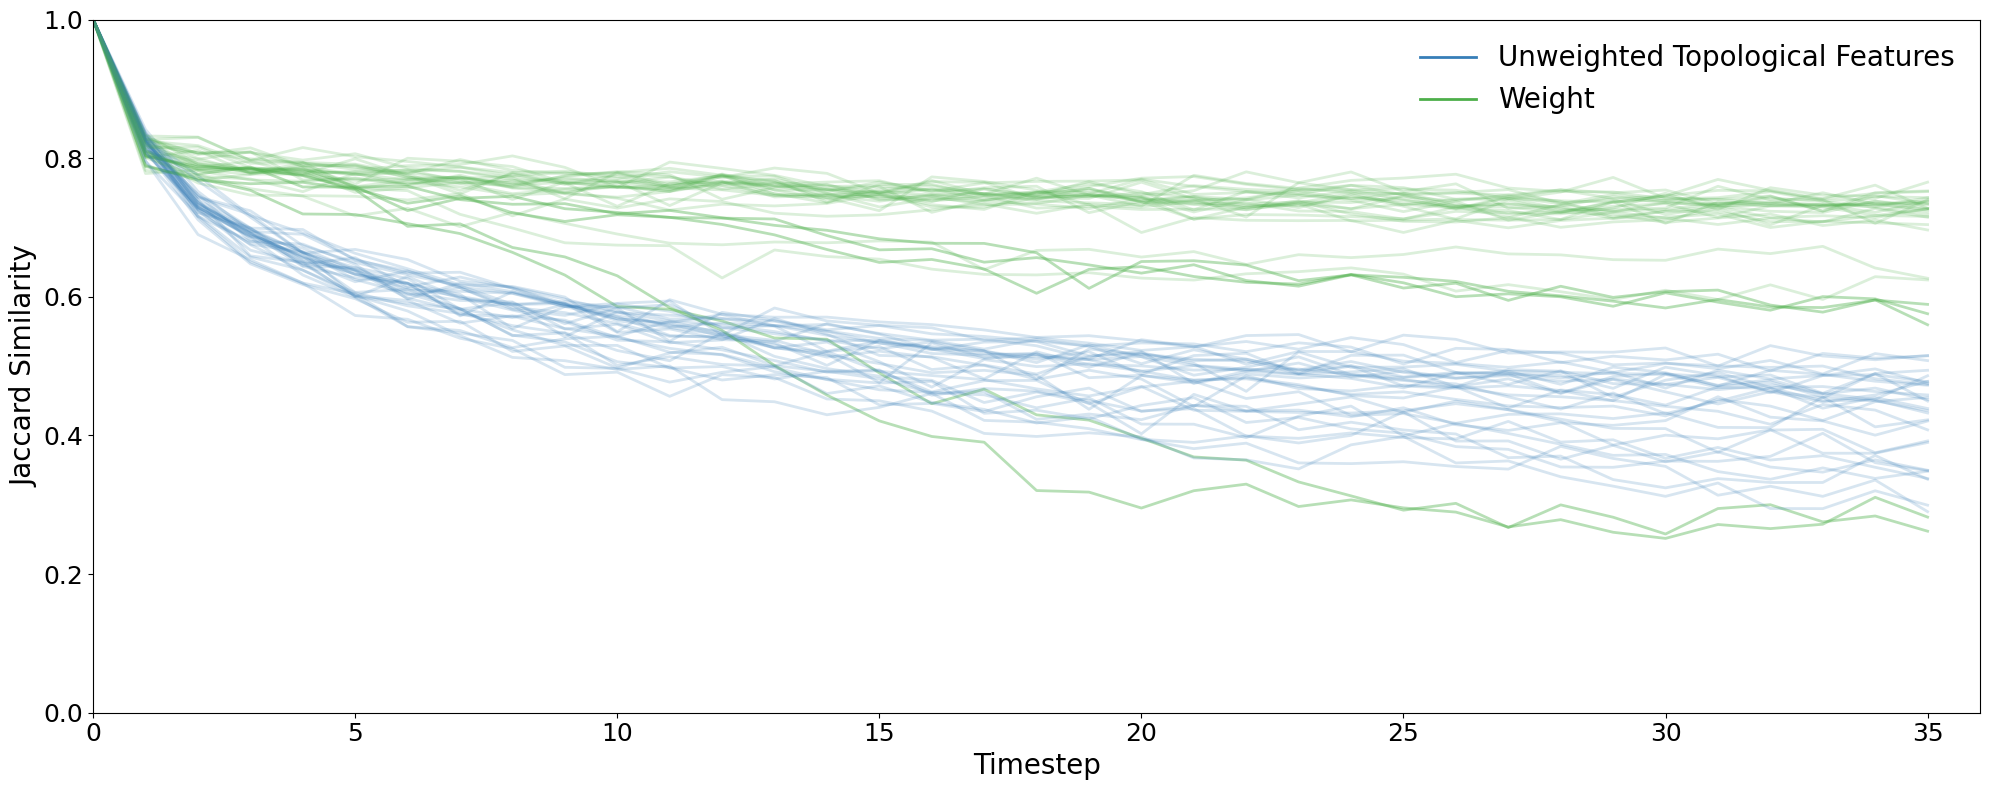

In [14]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

plt.figure(figsize=(20,8))
count = 0
for file in glob('data/prediction/2*pred_36.pkl'):
    with open(file,'rb') as f:    
        diff_btf,diff_www,btf_diff, www_diff = list(pickle.load(f).values())[0] 
        plt.plot(btf_diff,c='#377eb8',alpha=0.2,linewidth=2)
        if www_diff[-1]<=0.6:
            count+=1
            plt.plot(www_diff,c='#4daf4a',alpha=0.4,linewidth=2)
        else:       
            plt.plot(www_diff,c='#4daf4a',alpha=0.2,linewidth=2)

plt.plot([],[],c='#377eb8',label="Unweighted Topological Features",alpha=1,linewidth=2)
plt.plot([],[],c='#4daf4a',label="Weight",alpha=1,linewidth=2)
# plt.plot([],[],c='#e41a1c',label="Random",alpha=1,linewidth=2)

plt.ylabel('Jaccard Similarity', fontsize=20)
plt.xlabel('Timestep',fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,1)
plt.xlim(0,36)
plt.tight_layout()
plt.show()

### Error of WWW model

In [15]:
per_large_error = count/len(www_diff)
print('%.2f%%' % (per_large_error*100))

13.89%


### Prediction using BTF model (unweighted topological features)
According to the referred paper, the authors set up a hypothetical air travel restriction with two hypothesis:

there is a target Nf for the total number of edges in the network (Nm is the number of edges in the current snapshot)

a. Nf/Nm = 1/3

b. Nf/Nm = 1/5

at each time step we remove a fraction of existing edges (removing rate)

a. 0.02

b. 0.04

That is, they assumed that each month n edges will be removed from the network. (n = Nm * removing rate * (1 - Nf/Nm)).

Plus, based on their hypothesis, there will be no addition of edges in the future.

In our project, we use the model trained on August 2022 to predict the probability that a given edge is removed and remove it according to that probability. And following the paper, we assumed Nf/Nm = 1/3, removing rate = 0.02.

Then we remove edges from network at each month based on predicted probability and the number of edges to be removed.

In [16]:

def forecast(init_date,target_retained_fraction, remove_rate):

    data = pd.read_csv('data/features/usair_2004_2022.csv',index_col=0 )    # features file
    out = {}
    idx = air_dates.index(init_date)
    train, test = get_edge_slice(data)
    
    # train BTF model
    # BTF model feature: unweighted topological features
    features = ['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
           'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
           'Adamic Adar', 'Resource Allocation', 'Local Path'] 
           
    X_train, y_train, _ = df_to_XY(train[train.Year==str(init_date)],features)
    ros = RandomUnderSampler()
    X_train,y_train = ros.fit_resample(X_train,y_train)
    model_btf = XGBClassifier()
    model_btf.fit(X_train, y_train)
    model = model_btf
    graphs_btf = [graphs_air[idx]]
    
    # train xgboost regressor model to predict future weight
    best_params = {'lambda': 0.5650701862593042, 'alpha': 0.0016650896783581535,
           'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.009,
           'n_estimators': 625, 'objective':'reg:squarederror','max_depth': 5, 'min_child_weight': 6}
    features_reg = ['Curr Weight']
    X_train_reg, y_train_reg, y_reg = df_to_XY(train[train.Year==str(init_date)],features_reg)
    ros = RandomUnderSampler()
    model_reg = XGBRegressor(**best_params)
    model_reg.fit(X_train_reg, y_reg)

    for i in tqdm(range(0,60)): # prediction for 60 months
        G = graphs_btf[i].copy()
        for u,v in G.edges():
            G[u][v]['weight'] = model_reg.predict(float(G[u][v]['weight']))[0]
        df = get_feature_vector(G)
        edges, X = df['Edge'].to_numpy(),df[features].to_numpy()
        pred_prob = model.predict_proba(X).T[0]
        N_edges = G.number_of_edges()
        N_remove = int((N_edges * remove_rate * (1 - target_retained_fraction))) # hypothesis 1&2
        removal = zip(edges,pred_prob) 
        pred_removal = sorted(removal, key = lambda x: x[1])[0:N_remove] # sort removal probabilities of each edge
        remove_edges = [i for i,_ in pred_removal] # identify which edge should be removed
        G.remove_edges_from(remove_edges) # remove edges from the network
        graphs_btf.append(G.copy()) # store the predicted graph
    
    return graphs_btf 

In [20]:
# graphs_forecast = forecast(datetime.date(2022,8,1), 1/3, 0.02) 

file_path = []
for i in range(61):
    file_path.append('data/Prediction_Graphs/graph' + str(i) + '.pickle')
    
graphs_forecast2 = []
graph = nx.Graph()
for file in file_path:
    with open(file,'rb') as f:
        graph = pickle.load(f)
        graphs_forecast2.append(graph)

In [21]:
len(graphs_forecast2) 

61

### Result - retained edges

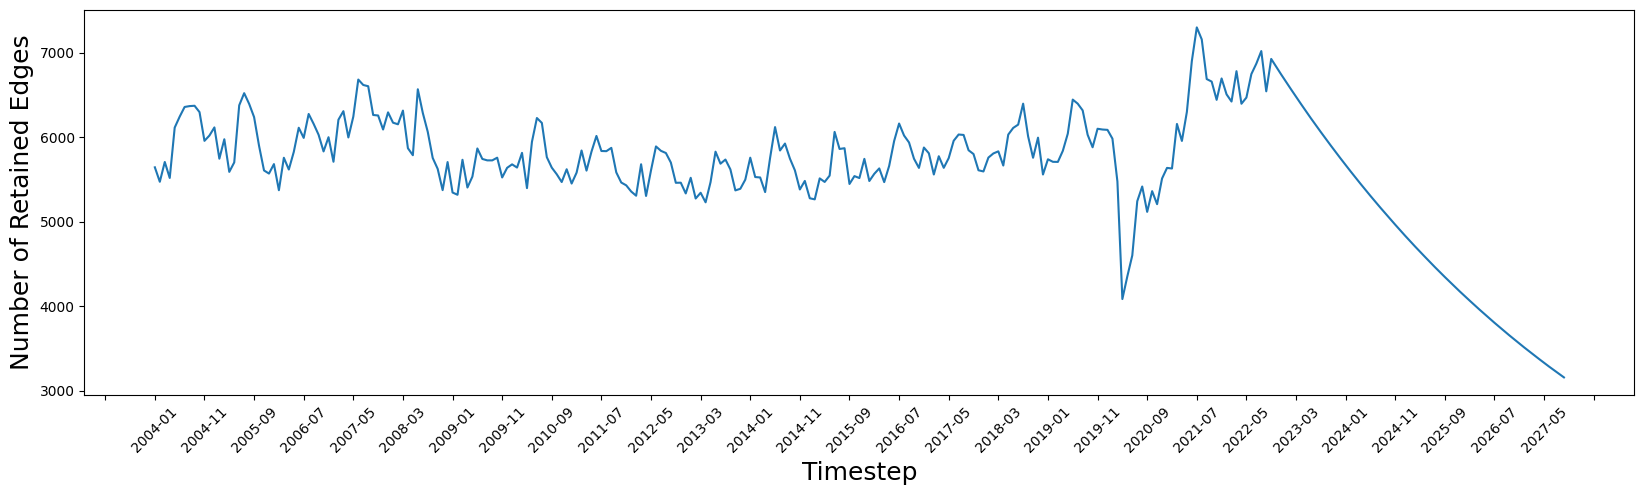

In [22]:
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator


# real change in number of edges from Jan. 2004 to Aug. 2022
num_of_edges_04_22 = []
for graph in graphs_air:
    num_of_edges_04_22.append(graph.number_of_edges())

# predicted change from Sept 2022 to Aug 2027
num_of_edges_22_27 = []
for graph in graphs_forecast2[1:]: # excluding the first graph of Aug 2022
    num_of_edges_22_27.append(graph.number_of_edges())

# combine number of edges lists for visualization
num_of_edges = num_of_edges_04_22
num_of_edges.extend(num_of_edges_22_27)

# create month list for plotting
start_date = datetime.datetime(2004, 1, 1)
end_date = datetime.datetime(2027, 9, 1)

month_list = []
current_date = start_date

while current_date <= end_date:
    month_list.append(current_date.strftime("%Y-%m"))
    current_date += relativedelta(months=1)
    
fig, ax = plt.subplots(figsize=(20,5))
date = month_list
values = num_of_edges
ax.plot(date,values)
ax.xaxis.set_major_locator(MultipleLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Number of Retained Edges', fontsize=18)
plt.xlabel('Timestep', fontsize=18)
plt.show()

Within five years, routes will be cut in half under our assumption.

### Result - retained time

In [24]:
# August 2022: the initial status
graph_init = graphs_forecast2[0]
edge_init = list(graph_init.edges())
degree_init = dict(graph_init.degree())

# August 2027: the forecast ending month
graph_end = graphs_forecast2[-1]
edge_end = list(graph_end.edges())
degree_end = dict(graph_end.degree())

# calculate the retained months for each edges(exist in August 2022) within the 60 months forecasting period
retain_months = {}
count = 0
for edge in edge_init:
    for graph in graphs_forecast2[1:]: # exclude the graph of Aug 2022
        if edge in graph.edges():
            count += 1
        retain_months[edge] = count
    retain_months[edge] = count
    count = 0
    
# create dataframe
retain_df = pd.DataFrame(list(retain_months.items()), columns=['edge','retained_month'])

# split edge to origin and target
retain_df[['origin', 'target']] = retain_df['edge'].apply(pd.Series) 

retain_df

,edge,retained_month,origin,target
0,"(aberdeen_sd, minneapolis_mn)",60,aberdeen_sd,minneapolis_mn
1,"(aberdeen_sd, sioux_falls_sd)",10,aberdeen_sd,sioux_falls_sd
2,"(aberdeen_sd, fargo_nd)",10,aberdeen_sd,fargo_nd
3,"(minneapolis_mn, albuquerque_nm)",51,minneapolis_mn,albuquerque_nm
4,"(minneapolis_mn, alexandria_la)",42,minneapolis_mn,alexandria_la
...,...,...,...,...
7014,"(west_point_ak, uganik_ak)",60,west_point_ak,uganik_ak
7015,"(santa_maria_ca, santa_ynez_ca)",60,santa_maria_ca,santa_ynez_ca
7016,"(monroe_nc, selinsgrove_pa)",60,monroe_nc,selinsgrove_pa
7017,"(st_michael_ak, stebbins_ak)",60,st_michael_ak,stebbins_ak


In [25]:
# count the frequency of each type of retained month
counts = pd.DataFrame(retain_df['retained_month'].value_counts())
counts.rename(columns={'retained_month':'count'},inplace=True)
counts['percentage'] = counts['count']/counts['count'].sum()
counts

,count,percentage
retained_month,,
60,3159,0.450064
0,93,0.013250
1,92,0.013107
2,91,0.012965
3,89,0.012680
...,...,...
54,45,0.006411
56,44,0.006269
57,43,0.006126


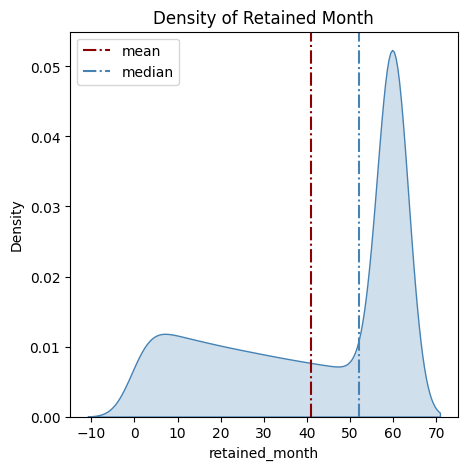

In [26]:
# plot kdeplot to check the density of all retained months 
plt.figure(figsize=(5,5))
sns.kdeplot(retain_df.retained_month,color='steelblue', shade=True)
plt.axvline(retain_df.retained_month.mean(), label='mean',linestyle='-.', color='darkred')
plt.axvline(retain_df.retained_month.median(), label='median',linestyle='-.', color='steelblue')
plt.legend()
plt.title('Density of Retained Month')
plt.show()

In [27]:
#calculate average retained months of edges groupby departure cities
group1 = retain_df.groupby('origin')
average_retained_month = pd.DataFrame(group1['retained_month'].mean())
sorted_mean_retained_month = average_retained_month.sort_values(by='retained_month')

### For most edges being retained, 60 months is the mode of retained time.

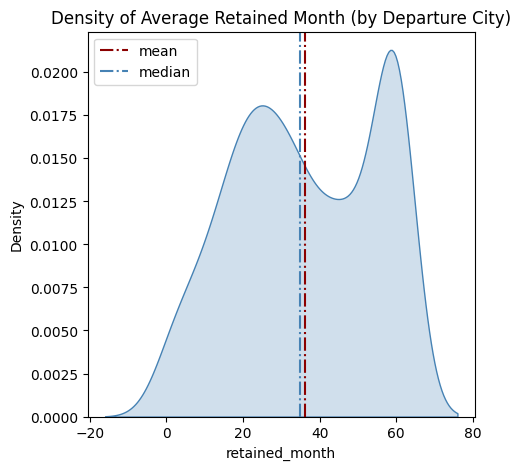

In [28]:
# plot kdeplot to check the density of average retained months (group by departure city) 
plt.figure(figsize=(5,5))
sns.kdeplot(sorted_mean_retained_month.retained_month,color='steelblue', shade=True)
plt.axvline(sorted_mean_retained_month.retained_month.mean(), label='mean',linestyle='-.', color='darkred')
plt.axvline(sorted_mean_retained_month.retained_month.median(), label='median',linestyle='-.', color='steelblue')
plt.legend(loc='upper left')
plt.title('Density of Average Retained Month (by Departure City)')
plt.show()

Average retained months of each cities vary.

60 months is still the mode, but the median and mean are lower.

This indicates that long-retained edges distribute in wide range of cities.

In [30]:
#calculate total retained months of all edges by departure cities
group = retain_df.groupby('origin')
sum_retained_month = pd.DataFrame(group['retained_month'].sum())
sorted_sum_retained_month = sum_retained_month.sort_values(by='retained_month')
# top 5 cities
sorted_sum_retained_month.tail(5)

,retained_month
origin,
detroit_mi,7542
minneapolis_mn,7571
denver_co,10077
chicago_il,10685
dallasfort_worth_tx,11397


Top 5 cities with largest number of total retained month:

Edges connecting hubs are important hubs in the us domestic airline networks

Due to their central location and extensive connections, edges connecting to them tend to have higher: hub promoted index; resource allocation index; and edge weights.

As we use unweighted topological features for modeling, a model that edges weights, hub promoted index and resource allocation index have largest predictive power, edges connecting to these hubs are less likely to be removed.

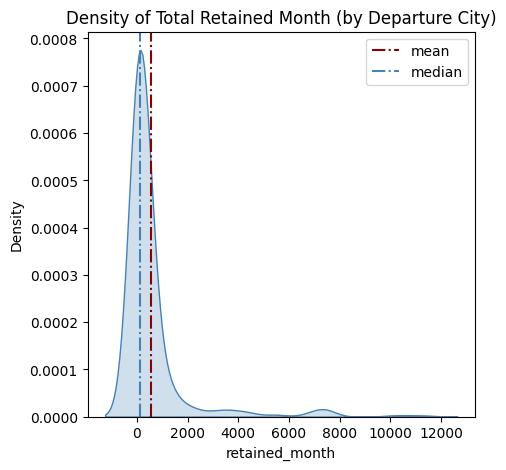

In [31]:
# plot kdeplot to check the density of total retained months (group by departure city) 
plt.figure(figsize=(5,5))
sns.kdeplot(sorted_sum_retained_month.retained_month,color='steelblue', shade=True)
plt.axvline(sorted_sum_retained_month.retained_month.mean(), label='mean',linestyle='-.', color='darkred')
plt.axvline(sorted_sum_retained_month.retained_month.median(), label='median',linestyle='-.', color='steelblue')
plt.legend(loc='upper right')
plt.title('Density of Total Retained Month (by Departure City)')
plt.show()

Most cities have small number of total retained time. There are several possible reasons:

most cities have small number of edges, and those edges do not remain for long time.

most cities have small number of edges, although those edges remain for long time.

We will further investigate the change of degree.

### Result - degree change

In [33]:
# get the degree of all edges at the very begining and the prediction end date
# calculate changes and percentage changes between two dates

df_init = pd.DataFrame.from_dict(degree_init, orient='index', columns=['degree_init'])
df_end = pd.DataFrame.from_dict(degree_end, orient='index', columns=['degree_end'])
degree_df = df_init.merge(df_end,left_index=True,right_index=True, how='outer')
degree_df['degree_change'] = degree_df['degree_init'] - degree_df['degree_end']
degree_df['per_change'] = degree_df['degree_change'] / degree_df['degree_init']
degree_df = degree_df.fillna(0)
degree_df.head()

,degree_init,degree_end,degree_change,per_change
aberdeen_sd,3,1,2,0.666667
minneapolis_mn,134,104,30,0.223881
sioux_falls_sd,30,13,17,0.566667
abilene_tx,20,3,17,0.850000
dallasfort_worth_tx,201,186,15,0.074627


In [34]:
sorted_degree_df = degree_df.sort_values(by='per_change')

sorted_degree_df.tail()

,degree_init,degree_end,degree_change,per_change
edgartown_ma,1,0,1,1.0
pontiac_mi,26,0,26,1.0
elko_nv,2,0,2,1.0
kapalua_hi,4,0,4,1.0
burlingtonmount_vernon_wa,2,0,2,1.0


### Result - CO2 Emission

In [36]:
distant_df = pd.read_csv('data/us_air_distance.csv')
distant_map = distant_df.set_index(['source_origin','target_origin']).to_dict()['distance']
distant_map.update(distant_df.set_index(['target_origin','source_origin']).to_dict()['distance'])

In [39]:
# calculate CO2 emission for each month in the future based on the prediction results
CO2_em = []
i = 1 # exclude graph of Aug 2022
CO2_edge = 0

# loop for emission of all month
while i < len(graphs_forecast2):
    
    # loop for emission of all edges on each month 
    for u,v in graphs_forecast2[i].edges(): 
        edge = (u,v) 
        if edge in distant_map:
            distance = distant_map[edge]
        weight = graphs_forecast2[i][u][v]['weight'] # the predicted number of flights during each month
        CO2_edge += 3.16 * 32.5 * distance * weight * (10 ** (-6)) # co2 emission for all edges in one month
        # monthly CO2 emission (in tons) = 3.16*32.5(gram fuel per km) * trip distance (in km) * number of flights each month * 10^-6 (tons/gram)
        
    CO2_em.append(CO2_edge) # store co2 emission for each month
    
    CO2_edge = 0 # for calculation of co2 emission on the next month
    i += 1

In [40]:
# create month list for plotting
start_date = datetime.datetime(2022, 9, 1)
end_date = datetime.datetime(2027, 8, 1)

month_list_2 = []
current_date = start_date

while current_date <= end_date:
    month_list_2.append(current_date.strftime("%Y-%m"))
    current_date += relativedelta(months=1)

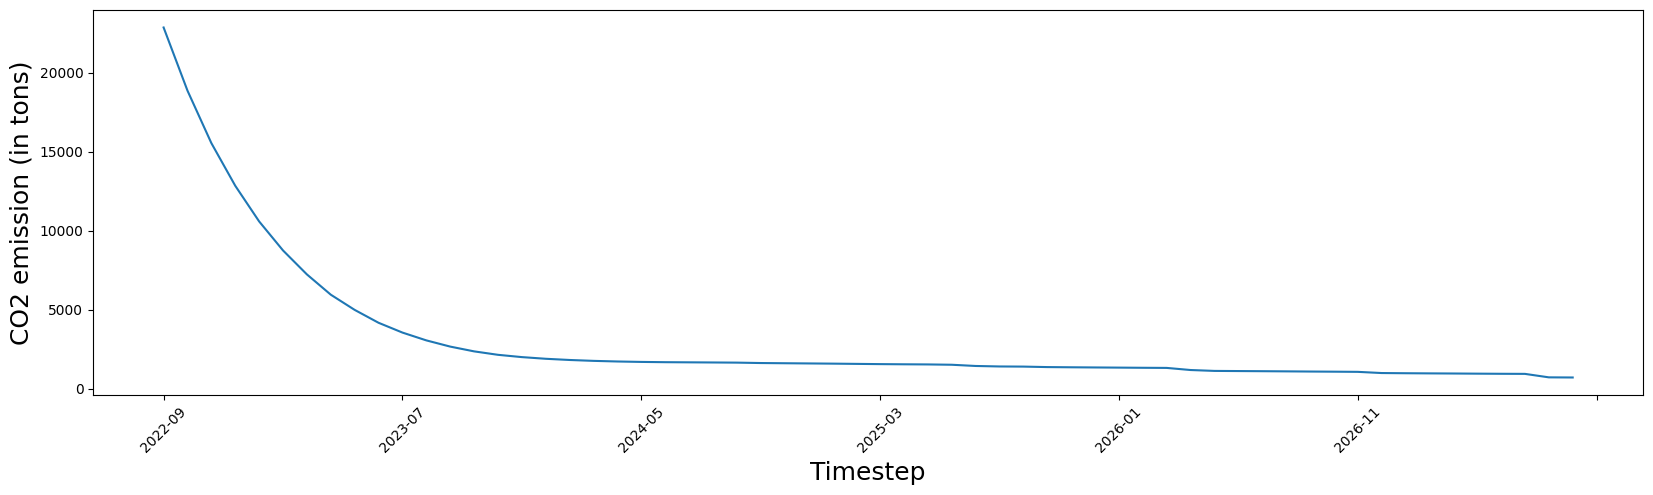

In [41]:
fig, ax = plt.subplots(figsize=(20,5))
date = month_list_2
values = CO2_em
ax.plot(date,values)
ax.xaxis.set_major_locator(MultipleLocator(10))
plt.xticks(rotation=45)
plt.ylabel('CO2 emission (in tons)', fontsize=18)
plt.xlabel('Timestep', fontsize=18)
plt.show()